# Projet Long - Zero-shot CLIP classifier sur CIFAR

## Setup

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1313c0e3-5131-cd12-6e22-c09abedeb54b)


In [ ]:
! pip install ftfy regex tqdm
! pip uninstall torch torchvision transformers mistral_inference -y
! pip install torch==2.6.0 torchvision==0.21.0 transformers mistral_inference
! pip install git+https://github.com/openai/CLIP.git

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Found existing installation: transformers 4.50.0
Uninstalling transformers-4.50.0:
  Successfully uninstalled transformers-4.50.0
Found existing installation: mistral_inference 1.6.0
Uninstalling mistral_inference-1.6.0:
  Successfully uninstalled mistral_inference-1.6.0
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached transformers-4.50.0-py3-none-any.whl.metadata (39 kB)
  Using cached mistral_inference-1.6.0-py3-none-any.whl.metadata (17 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
Using cached transformers-4.50.0-py3-none-an

In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert list(map(int, torch.__version__.split("+")[0].split("."))) >= [1, 7, 1], "PyTorch 1.7.1 or later is required"

Torch version: 2.6.0+cu124


## Load model

In [ ]:
import clip

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("RN50")
#model, preprocess = clip.load("ViT-B/16")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
import os

from torchvision.datasets import CIFAR10

cifar10 = CIFAR10(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)

In [ ]:
cifar10

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /root/.cache
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7aeb0ee42de0>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )

In [ ]:
len(cifar10)

10000

In [ ]:
img, label = next(iter(cifar10))

In [ ]:
norm = preprocess.transforms[-1]
def denormalize(img):
  return img * torch.tensor(norm.std)[:, None, None] + torch.tensor(norm.mean)[:, None, None]
norm.mean, norm.std

((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

(torch.Size([224, 224, 3]), tensor(0.0431), tensor(1.))

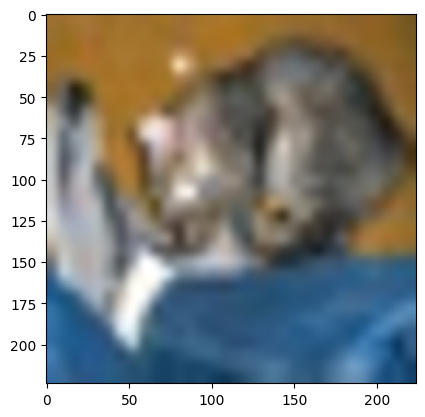

In [ ]:
import matplotlib.pyplot as plt

img, label = next(iter(cifar10))
img = denormalize(img).permute(1, 2, 0)
plt.imshow(img)
img.shape, img.min(), img.max()

In [ ]:
batch_size = 1
data_loader = torch.utils.data.DataLoader(cifar10,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
x = next(iter(data_loader))
x[0].shape, x[1].shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

## A photo of a [Class]

In [ ]:
simple_template = ["a photo of a {}."]

In [ ]:
zeroshot_weights_simple = zeroshot_classifier(cifar10.classes, simple_template)

In [ ]:
with torch.no_grad():
  top1_simple, top5_simple, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights_simple
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1_simple += acc1
    top5_simple += acc5

    n += images.size(0)

top1_simple = (top1_simple / n) * 100
top5_simple = (top5_simple / n) * 100

print()
print(f"Top-1 accuracy with simple template: {top1_simple:.2f}")
print(f"Top-5 accuracy with simple template: {top5_simple:.2f}")

## Use of a LLM to enhance prompts

### Chargement de Mistral7B

In [ ]:

from google.colab import userdata


In [ ]:
!nvidia-smi
!pip install requests transformers accelerate
!pip install -U bitsandbytes

Mon Mar 24 17:06:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             28W /   70W |     360MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print(torch.cuda.is_available())
import requests
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

True


In [ ]:
model_id = 'mistralai/Mistral-7B-Instruct-v0.3'
tokenizer = AutoTokenizer.from_pretrained(model_id, token=userdata.get('HF_TOKEN'))
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16
)  # configuration pour la quantification en 8 bits
model_llm = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto", token=userdata.get('HF_TOKEN'))

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Prompts pour obtenir les attributs

In [ ]:
import random
import re
import json


def get_attributes(classname):
    prompt = (
        f"Please generate three visual attributes that are easy to see in an image of a {classname}. "
        "Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
    outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.5, top_k=20)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        # Extract attributes from the generated text
        json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
            attributes = json.loads(json_text)
            if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
                return attributes["feature1"], attributes["feature2"], attributes["feature3"]
            else:
                raise ValueError("Missing JSON keys")
        else:
            # Fallback if no JSON is found
            parts = generated_text.split(',')
            if len(parts) >= 3:
                return parts[0].strip(), parts[1].strip(), parts[2].strip()

        # Fallback in case of errors
        print(f"Using fallback for '{classname}'")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error processing generated text for '{classname}': {e}")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"



def get_attributes2(classname, best_attribute):
  prompt = (
        f"Please generate three visual attributes that are easy to see in an image of a {classname}, "
        f"other than '{best_attribute}', which is already chosen. Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

  inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
  outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.5, top_k=20)
  generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

  try:
    # Extract attributes from the generated text
    json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
    if json_match:
      json_text = json_match.group(0)
      attributes = json.loads(json_text)
      if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
        return attributes["feature1"], attributes["feature2"], attributes["feature3"]
      else:
        raise ValueError("Missing JSON keys")
    else:
      # Fallback if no JSON is found
      parts = generated_text.split(',')
      if len(parts) >= 3:
        return parts[0].strip(), parts[1].strip(), parts[2].strip()

    # Fallback in case of errors
    print(f"Using fallback for '{classname}'")
    return "unknown_feature1", "unknown_feature2", "unknown_feature3"

  except (json.JSONDecodeError, ValueError) as e:
    print(f"Error processing generated text for '{classname}': {e}")
    return "unknown_feature1", "unknown_feature2", "unknown_feature3"



def get_attributes3(classname, best_attribute, best_attribute2):
  prompt = (
        f"Please generate three visual attributes that are easy to see in an image of a {classname}, "
        f"other than '{best_attribute}' and '{best_attribute2}', which are already chosen. Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

  inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
  outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.5, top_k=20)
  generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

  try:
    # Extract attributes from the generated text
    json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
    if json_match:
      json_text = json_match.group(0)
      attributes = json.loads(json_text)
      if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
        return attributes["feature1"], attributes["feature2"], attributes["feature3"]
      else:
        raise ValueError("Missing JSON keys")
    else:
      # Fallback if no JSON is found
      parts = generated_text.split(',')
      if len(parts) >= 3:
        return parts[0].strip(), parts[1].strip(), parts[2].strip()

    # Fallback in case of errors
    print(f"Using fallback for '{classname}'")
    return "unknown_feature1", "unknown_feature2", "unknown_feature3"

  except (json.JSONDecodeError, ValueError) as e:
    print(f"Error processing generated text for '{classname}': {e}")
    return "unknown_feature1", "unknown_feature2", "unknown_feature3"


def get_random_attributes():
    prompt = (f"Please generate three random words describing an object. "
        "Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
    outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7, top_k=20)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        # Extract attributes from the generated text
        json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
            attributes = json.loads(json_text)
            if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
                return attributes["feature1"], attributes["feature2"], attributes["feature3"]
            else:
                raise ValueError("Missing JSON keys")
        else:
            # Fallback if no JSON is found
            parts = generated_text.split(',')
            if len(parts) >= 3:
                return parts[0].strip(), parts[1].strip(), parts[2].strip()

        # Fallback in case of errors
        print(f"Using fallback for random")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error processing generated text for random: {e}")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

def get_random_attributes2(best_attribute):
    prompt = (f"Please generate three random words describing an object, other than '{best_attribute}', which is already chosen. "
        "Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
    outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7, top_k=20)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        # Extract attributes from the generated text
        json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
            attributes = json.loads(json_text)
            if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
                return attributes["feature1"], attributes["feature2"], attributes["feature3"]
            else:
                raise ValueError("Missing JSON keys")
        else:
            # Fallback if no JSON is found
            parts = generated_text.split(',')
            if len(parts) >= 3:
                return parts[0].strip(), parts[1].strip(), parts[2].strip()

        # Fallback in case of errors
        print(f"Using fallback for random")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error processing generated text for random: {e}")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

def get_random_attributes3(best_attribute, best_attribute2):
    prompt = (f"Please generate three random words describing an object, other than '{best_attribute}' and '{best_attribute2}', which are already chosen. "
        "Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
    outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7, top_k=20)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        # Extract attributes from the generated text
        json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
            attributes = json.loads(json_text)
            if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
                return attributes["feature1"], attributes["feature2"], attributes["feature3"]
            else:
                raise ValueError("Missing JSON keys")
        else:
            # Fallback if no JSON is found
            parts = generated_text.split(',')
            if len(parts) >= 3:
                return parts[0].strip(), parts[1].strip(), parts[2].strip()

        # Fallback in case of errors
        print(f"Using fallback for random")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error processing generated text for random: {e}")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

In [ ]:
print(get_random_attributes())
print(get_random_attributes2('Red'))
print(get_random_attributes3('Red', 'Round'))


In [ ]:
# Exemple d'utilisation sur plusieurs classes
classes = ["apple", "aquarium_fish", "baby", "bear", "beaver", "bed"]
for cls in classes:
    attrs = get_attributes(cls)
    print(f"{cls}: {attrs}\n")
classes = ["apple", "aquarium_fish", "baby", "bear", "beaver", "bed"]
print(get_random_attributes())

### Classification

In [ ]:
def zeroshot_classifier_with_attributes(classnames, templates):
  with torch.no_grad():
    zeroshot_weights = []
    for classname in tqdm.tqdm(classnames):
      texts = templates[classname] #format with class
      texts = clip.tokenize(texts).cuda() #tokenize
      class_embeddings = model.encode_text(texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
  return zeroshot_weights

In [ ]:
def accuracy(output, target, topk=(1,)):
  pred = output.topk(max(topk), 1, True, True)[1].t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

#### pour 1 attribut

In [ ]:
best_attributes = {}

In [ ]:
def get_best_attribute(classe_idx, type='llm'):
    classe_studied_idx = classe_idx
    classe_studied = cifar10.classes[classe_studied_idx]

    if type == 'llm':
        attributes = get_attributes(classe_studied)
        print('Class :' + classe_studied)
        print(attributes)
    else:
        attributes = get_random_attributes()  # Get a single random attribute
        print('Class :' + classe_studied)
        print(attributes)

    best_attribute1 = None
    best_acc1 = 0

    templates = {classe: f"a photo of a {classe}" for classe in cifar10.classes}

    for attribute in attributes:
        templates[classe_studied] = [f"a photo of a {classe_studied} because of {attribute}"]

        zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates)

        with torch.no_grad():
            top1, top5, n = 0., 0., 0.
            for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
                if target == classe_studied_idx:
                    images = images.cuda()
                    target = target.cuda()

                    # predict
                    image_features = model.encode_image(images)
                    image_features /= image_features.norm(dim=-1, keepdim=True)

                    # measure accuracy
                    logits = 100. * image_features @ zeroshot_weights
                    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
                    top1 += acc1
                    top5 += acc5

                    n += images.size(0)

        top1 = (top1 / n) * 100
        top5 = (top5 / n) * 100

        print()
        print(f"Top-1 accuracy for {classe_studied}: {top1:.2f}")

        if top1 > best_acc1:
            best_acc1 = top1
            best_attribute1 = attribute

    return best_attribute1

In [ ]:
# Let's create the best templates :
import tqdm

for i in range(10):
  best_attributes[cifar10.classes[i]] = get_best_attribute(i, type='llm')
  print(f'{cifar10.classes[i]} best attribute : {best_attributes[cifar10.classes[i]]}')

best_templates = {}

for classe in cifar10.classes:
  best_templates[classe] = [f"a photo of a {classe} because of {best_attributes[classe]}"]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Class :airplane
('winged', 'long', 'streamlined')


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-27-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [00:26<00:00, 375.96it/s]



Top-1 accuracy for airplane: 91.70


100%|██████████| 10000/10000 [00:26<00:00, 379.40it/s]



Top-1 accuracy for airplane: 94.40


100%|██████████| 10000/10000 [00:27<00:00, 363.06it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for airplane: 82.10
airplane best attribute : long
Class :automobile
('four-door', 'red-color', 'tinted-windows')


100%|██████████| 10000/10000 [00:27<00:00, 357.85it/s]



Top-1 accuracy for automobile: 96.20


100%|██████████| 10000/10000 [00:29<00:00, 342.26it/s]



Top-1 accuracy for automobile: 92.70


100%|██████████| 10000/10000 [00:26<00:00, 376.49it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for automobile: 95.00
automobile best attribute : four-door
Class :bird
('feather color', 'beak shape', 'tail shape')


100%|██████████| 10000/10000 [00:26<00:00, 372.16it/s]



Top-1 accuracy for bird: 89.60


100%|██████████| 10000/10000 [00:26<00:00, 378.14it/s]



Top-1 accuracy for bird: 95.50


100%|██████████| 10000/10000 [00:26<00:00, 374.77it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for bird: 90.30
bird best attribute : beak shape
Class :cat
('fur_color', 'eye_color', 'whiskers_length')


100%|██████████| 10000/10000 [00:26<00:00, 371.20it/s]



Top-1 accuracy for cat: 96.70


100%|██████████| 10000/10000 [00:27<00:00, 366.41it/s]



Top-1 accuracy for cat: 91.30


100%|██████████| 10000/10000 [00:26<00:00, 371.09it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for cat: 91.20
cat best attribute : fur_color
Class :deer
('spotted coat', 'large ears', 'long tail')


100%|██████████| 10000/10000 [00:26<00:00, 371.59it/s]



Top-1 accuracy for deer: 53.70


100%|██████████| 10000/10000 [00:28<00:00, 356.39it/s]



Top-1 accuracy for deer: 71.40


100%|██████████| 10000/10000 [00:26<00:00, 371.78it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for deer: 91.60
deer best attribute : long tail
Class :dog
('fur_color', 'eye_color', 'ear_shape')


100%|██████████| 10000/10000 [00:26<00:00, 370.56it/s]



Top-1 accuracy for dog: 94.80


100%|██████████| 10000/10000 [00:26<00:00, 373.14it/s]



Top-1 accuracy for dog: 80.80


100%|██████████| 10000/10000 [00:26<00:00, 373.31it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for dog: 88.30
dog best attribute : fur_color
Class :frog
('green', 'pointy', 'webbed feet')


100%|██████████| 10000/10000 [00:26<00:00, 378.12it/s]



Top-1 accuracy for frog: 28.60


100%|██████████| 10000/10000 [00:26<00:00, 378.28it/s]



Top-1 accuracy for frog: 50.40


100%|██████████| 10000/10000 [00:26<00:00, 375.23it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for frog: 76.20
frog best attribute : webbed feet
Class :horse
('coat_color', 'mane_length', 'eye_color')


100%|██████████| 10000/10000 [00:27<00:00, 360.03it/s]



Top-1 accuracy for horse: 96.40


100%|██████████| 10000/10000 [00:26<00:00, 377.03it/s]



Top-1 accuracy for horse: 95.70


100%|██████████| 10000/10000 [00:26<00:00, 376.44it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for horse: 91.60
horse best attribute : coat_color
Class :ship
('Horizontal stripes', 'Tall mast', 'Large sails')


100%|██████████| 10000/10000 [00:26<00:00, 373.01it/s]



Top-1 accuracy for ship: 93.00


100%|██████████| 10000/10000 [00:27<00:00, 369.46it/s]



Top-1 accuracy for ship: 60.70


100%|██████████| 10000/10000 [00:26<00:00, 373.50it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for ship: 77.70
ship best attribute : Horizontal stripes
Class :truck
('Rectangular shape', 'Large size', 'Wheels')


100%|██████████| 10000/10000 [00:26<00:00, 377.54it/s]



Top-1 accuracy for truck: 95.20


100%|██████████| 10000/10000 [00:26<00:00, 375.66it/s]



Top-1 accuracy for truck: 68.70


100%|██████████| 10000/10000 [00:26<00:00, 376.91it/s]


Top-1 accuracy for truck: 12.70
truck best attribute : Rectangular shape


In [ ]:
zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, best_templates)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-27-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [01:56<00:00, 85.92it/s]


Top-1 accuracy: 72.91
Top-5 accuracy: 97.93


In [ ]:
from google.colab import drive
import json
import os

# Mount Google Drive
drive.mount('/content/drive')

if top1 >= 72.90:
  # Create the directory if it doesn't exist
  save_directory = '/content/drive/MyDrive/TRIED/ProjetLong'
  os.makedirs(save_directory, exist_ok=True)

  # Save best_attributes as a JSON file in the specified directory
  save_path = os.path.join(save_directory, 'best_attributes.json')
  with open(save_path, 'w') as f:
      json.dump(best_attributes, f)

  print(f"best_attributes saved to {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
best_attributes saved to /content/drive/MyDrive/TRIED/ProjetLong/best_attributes.json


#### Pour 2 attributs

In [ ]:
from google.colab import drive
import json
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load best_attributes from JSON file
file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes.json'
with open(file_path, 'r') as f:
    best_attributes = json.load(f)

best_attributes


Mounted at /content/drive


{'airplane': 'long',
 'automobile': 'four-door',
 'bird': 'beak shape',
 'cat': 'fur_color',
 'deer': 'long tail',
 'dog': 'fur_color',
 'frog': 'webbed feet',
 'horse': 'coat_color',
 'ship': 'Horizontal stripes',
 'truck': 'Rectangular shape'}

In [ ]:
def get_best_attribute2(classe_idx, type='llm'):
    classe_studied = cifar10.classes[classe_idx]

    if type == 'llm':
        best_attribute = best_attributes[classe_studied]
        attributes = get_attributes2(classe_studied, best_attribute)
    else:
        raise ValueError("Invalid type argument. Choose 'llm' or 'random'.")

    print('Class :' + classe_studied)
    print(attributes)

    best_attribute2 = None
    best_acc2 = 0

    templates = {classe: f"a photo of a {classe}" for classe in cifar10.classes}


    for attribute in attributes:
        if type == 'llm':
            templates[classe_studied] = [f"a photo of a {classe_studied} because of {best_attribute} and {attribute}"]



        zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates)

        with torch.no_grad():
            top1, top5, n = 0., 0., 0.
            for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
                if target == classe_idx:
                    images = images.cuda()
                    target = target.cuda()

                    # predict
                    image_features = model.encode_image(images)
                    image_features /= image_features.norm(dim=-1, keepdim=True)

                    # measure accuracy
                    logits = 100. * image_features @ zeroshot_weights
                    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
                    top1 += acc1
                    top5 += acc5

                    n += images.size(0)

            top1 = (top1 / n) * 100
            top5 = (top5 / n) * 100

        print()
        print(f"Top-1 accuracy for {classe_studied}: {top1:.2f}")

        if top1 > best_acc2:
            best_acc2 = top1
            best_attribute2 = attribute  #best_attribute2 est le deuxième attribut dans ce cas


    return best_attribute2 # on renvoie best_attribute2, qui sera attribute dans le cas random

In [ ]:
import tqdm

best_attributes2 = {}
for i in range(10):
  best_attributes2[cifar10.classes[i]] = get_best_attribute2(i, type="llm")
  print(f'{cifar10.classes[i]} best attribute 2: {best_attributes2[cifar10.classes[i]]}')

best_templates2 = {}
for classe in cifar10.classes:
  best_templates2[classe] = [f"a photo of a {classe} because of {best_attributes[classe]} and {best_attributes2[classe]}"]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Class :airplane
('winged', 'multi-engine', 'tail-finned')


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-21-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [00:27<00:00, 370.23it/s]



Top-1 accuracy for airplane: 93.90


100%|██████████| 10000/10000 [00:26<00:00, 374.16it/s]



Top-1 accuracy for airplane: 93.40


100%|██████████| 10000/10000 [00:27<00:00, 367.38it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for airplane: 96.80
airplane best attribute 2: tail-finned
Class :automobile
('red color', 'sporty design', 'tinted windows')


100%|██████████| 10000/10000 [00:28<00:00, 356.44it/s]



Top-1 accuracy for automobile: 90.80


100%|██████████| 10000/10000 [00:28<00:00, 356.58it/s]



Top-1 accuracy for automobile: 96.40


100%|██████████| 10000/10000 [00:26<00:00, 374.26it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for automobile: 95.60
automobile best attribute 2: sporty design
Class :bird
('wing color', 'tail length', 'leg color')


100%|██████████| 10000/10000 [00:27<00:00, 370.00it/s]



Top-1 accuracy for bird: 93.00


100%|██████████| 10000/10000 [00:27<00:00, 364.12it/s]



Top-1 accuracy for bird: 96.80


100%|██████████| 10000/10000 [00:26<00:00, 379.48it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for bird: 91.20
bird best attribute 2: tail length
Class :cat
('whiskers_length', 'ear_size', 'eye_color')


100%|██████████| 10000/10000 [00:26<00:00, 379.38it/s]



Top-1 accuracy for cat: 97.60


100%|██████████| 10000/10000 [00:26<00:00, 377.73it/s]



Top-1 accuracy for cat: 95.40


100%|██████████| 10000/10000 [00:26<00:00, 372.64it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for cat: 92.50
cat best attribute 2: whiskers_length
Class :deer
('spotted coat', 'large ears', 'white underbelly')


100%|██████████| 10000/10000 [00:27<00:00, 366.09it/s]



Top-1 accuracy for deer: 84.20


100%|██████████| 10000/10000 [00:26<00:00, 372.62it/s]



Top-1 accuracy for deer: 91.10


100%|██████████| 10000/10000 [00:27<00:00, 367.67it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for deer: 89.10
deer best attribute 2: large ears
Class :dog
('eye_color', 'ear_shape', 'tail_curl')


100%|██████████| 10000/10000 [00:26<00:00, 371.56it/s]



Top-1 accuracy for dog: 88.50


100%|██████████| 10000/10000 [00:27<00:00, 362.85it/s]



Top-1 accuracy for dog: 93.70


100%|██████████| 10000/10000 [00:27<00:00, 369.36it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for dog: 94.10
dog best attribute 2: tail_curl
Class :frog
('green skin', 'long tongue', 'large eyes')


100%|██████████| 10000/10000 [00:32<00:00, 308.62it/s]



Top-1 accuracy for frog: 74.70


100%|██████████| 10000/10000 [00:26<00:00, 377.67it/s]



Top-1 accuracy for frog: 76.00


100%|██████████| 10000/10000 [00:27<00:00, 368.34it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for frog: 79.00
frog best attribute 2: large eyes
Class :horse
('mane_length', 'ear_position', 'tail_curl')


100%|██████████| 10000/10000 [00:26<00:00, 374.22it/s]



Top-1 accuracy for horse: 98.30


100%|██████████| 10000/10000 [00:26<00:00, 373.79it/s]



Top-1 accuracy for horse: 97.20


100%|██████████| 10000/10000 [00:26<00:00, 374.10it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for horse: 96.50
horse best attribute 2: mane_length
Class :ship
('Square sails', 'Tall mast', 'Anchors hanging')


100%|██████████| 10000/10000 [00:26<00:00, 371.04it/s]



Top-1 accuracy for ship: 93.80


100%|██████████| 10000/10000 [00:27<00:00, 369.89it/s]



Top-1 accuracy for ship: 80.10


100%|██████████| 10000/10000 [00:27<00:00, 357.71it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for ship: 91.10
ship best attribute 2: Square sails
Class :truck
('Grille design', 'Tire size', 'Paint color')


100%|██████████| 10000/10000 [00:26<00:00, 373.76it/s]



Top-1 accuracy for truck: 54.30


100%|██████████| 10000/10000 [00:27<00:00, 361.08it/s]



Top-1 accuracy for truck: 83.40


100%|██████████| 10000/10000 [00:26<00:00, 376.91it/s]


Top-1 accuracy for truck: 83.60
truck best attribute 2: Paint color


In [ ]:
zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, best_templates2)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-21-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [01:52<00:00, 88.94it/s]



Top-1 accuracy: 70.75
Top-5 accuracy: 97.55


In [ ]:
print(best_templates2)

save_directory = '/content/drive/MyDrive/TRIED/ProjetLong'
os.makedirs(save_directory, exist_ok=True)

if top1 >= 70.75:
  # Save best_attributes as a JSON file in the specified directory
  save_path = os.path.join(save_directory, 'best_attributes2.json')
  with open(save_path, 'w') as f:
    json.dump(best_attributes2, f)

  print(f"best_attributes2 saved to {save_path}")


{'airplane': ['a photo of a airplane because of long and tail-finned'], 'automobile': ['a photo of a automobile because of four-door and sporty design'], 'bird': ['a photo of a bird because of beak shape and tail length'], 'cat': ['a photo of a cat because of fur_color and whiskers_length'], 'deer': ['a photo of a deer because of long tail and large ears'], 'dog': ['a photo of a dog because of fur_color and tail_curl'], 'frog': ['a photo of a frog because of webbed feet and large eyes'], 'horse': ['a photo of a horse because of coat_color and mane_length'], 'ship': ['a photo of a ship because of Horizontal stripes and Square sails'], 'truck': ['a photo of a truck because of Rectangular shape and Paint color']}
best_attributes2 saved to /content/drive/MyDrive/TRIED/ProjetLong/best_attributes2.json


#### Pour 3 attributs

In [ ]:
from google.colab import drive
import json
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load best_attributes from JSON file
file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes2.json'
with open(file_path, 'r') as f:
    best_attributes2 = json.load(f)

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes.json'
with open(file_path, 'r') as f:
    best_attributes = json.load(f)

print(best_attributes)
print(best_attributes2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'airplane': 'long', 'automobile': 'four-door', 'bird': 'beak shape', 'cat': 'fur_color', 'deer': 'long tail', 'dog': 'fur_color', 'frog': 'webbed feet', 'horse': 'coat_color', 'ship': 'Horizontal stripes', 'truck': 'Rectangular shape'}
{'airplane': 'tail-finned', 'automobile': 'sporty design', 'bird': 'tail length', 'cat': 'whiskers_length', 'deer': 'large ears', 'dog': 'tail_curl', 'frog': 'large eyes', 'horse': 'mane_length', 'ship': 'Square sails', 'truck': 'Paint color'}


In [ ]:
def get_best_attribute3(classe_idx, type='llm'):
    classe_studied = cifar10.classes[classe_idx]

    if type == 'llm':
        best_attribute = best_attributes[classe_studied]
        best_attribute2 = best_attributes2[classe_studied]
        attributes = get_attributes3(classe_studied, best_attribute, best_attribute2)
    else:
        raise ValueError("Invalid type argument. Choose 'llm' or 'random'.")

    print('Class :' + classe_studied)
    print(attributes)  # attributes will contain only the third attribute in the random case

    best_attribute3 = None
    best_acc3 = 0

    templates = {classe: f"a photo of a {classe}" for classe in cifar10.classes}

    for attribute in attributes:  # This loop will iterate only once in the random case
        if type == 'llm':
            templates[classe_studied] = [f"a photo of a {classe_studied} because of {best_attribute} and {best_attribute2} and {attribute}"]

        zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates)

        with torch.no_grad():
            top1, top5, n = 0., 0., 0.
            for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
                if target == classe_idx:
                    images = images.cuda()
                    target = target.cuda()

                    # predict
                    image_features = model.encode_image(images)
                    image_features /= image_features.norm(dim=-1, keepdim=True)

                    # measure accuracy
                    logits = 100. * image_features @ zeroshot_weights
                    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
                    top1 += acc1
                    top5 += acc5

                    n += images.size(0)

            top1 = (top1 / n) * 100
            top5 = (top5 / n) * 100

        print()
        print(f"Top-1 accuracy for {classe_studied}: {top1:.2f}")

        if top1 > best_acc3:
            best_acc3 = top1
            best_attribute3 = attribute

    return best_attribute3  # Returns the third attribute, which will be attribute3 in the random case

In [ ]:
best_attributes3 = {}
for i in range(10):
  best_attributes3[cifar10.classes[i]] = get_best_attribute3(i, type="llm")
  print(f'{cifar10.classes[i]} best attribute 3: {best_attributes3[cifar10.classes[i]]}')

best_templates3 = {}
for classe in cifar10.classes:
  best_templates3[classe] = [f"a photo of a {classe} because of {best_attributes[classe]} and {best_attributes2[classe]} and {best_attributes3[classe]}"]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Class :airplane
('winged', 'jet-engine', 'fuselage-long')


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-21-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [00:26<00:00, 370.99it/s]



Top-1 accuracy for airplane: 97.40


100%|██████████| 10000/10000 [00:27<00:00, 369.07it/s]



Top-1 accuracy for airplane: 97.00


100%|██████████| 10000/10000 [00:27<00:00, 368.71it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for airplane: 99.00
airplane best attribute 3: fuselage-long
Class :automobile
('Red color', 'Four wheels', 'Tinted windows')


100%|██████████| 10000/10000 [00:26<00:00, 375.81it/s]



Top-1 accuracy for automobile: 91.40


100%|██████████| 10000/10000 [00:28<00:00, 353.21it/s]



Top-1 accuracy for automobile: 98.50


100%|██████████| 10000/10000 [00:26<00:00, 375.58it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for automobile: 92.80
automobile best attribute 3: Four wheels
Class :bird
('feather color', 'leg color', 'eye color')


100%|██████████| 10000/10000 [00:26<00:00, 373.14it/s]



Top-1 accuracy for bird: 94.40


100%|██████████| 10000/10000 [00:26<00:00, 373.43it/s]



Top-1 accuracy for bird: 93.20


100%|██████████| 10000/10000 [00:26<00:00, 371.50it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for bird: 93.30
bird best attribute 3: feather color
Class :cat
('ear_shape', 'eye_color', 'tail_curl')


100%|██████████| 10000/10000 [00:27<00:00, 364.45it/s]



Top-1 accuracy for cat: 97.50


100%|██████████| 10000/10000 [00:27<00:00, 368.22it/s]



Top-1 accuracy for cat: 95.60


100%|██████████| 10000/10000 [00:27<00:00, 368.38it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for cat: 96.60
cat best attribute 3: ear_shape
Class :deer
('spotted coat', 'white underbelly', 'large antlers')


100%|██████████| 10000/10000 [00:26<00:00, 371.60it/s]



Top-1 accuracy for deer: 90.60


100%|██████████| 10000/10000 [00:26<00:00, 372.12it/s]



Top-1 accuracy for deer: 88.80


100%|██████████| 10000/10000 [00:26<00:00, 372.42it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for deer: 88.10
deer best attribute 3: spotted coat
Class :dog
('eye_shape', 'ear_size', 'nose_color')


100%|██████████| 10000/10000 [00:26<00:00, 373.05it/s]



Top-1 accuracy for dog: 96.20


100%|██████████| 10000/10000 [00:26<00:00, 372.34it/s]



Top-1 accuracy for dog: 95.80


100%|██████████| 10000/10000 [00:26<00:00, 371.52it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for dog: 94.90
dog best attribute 3: eye_shape
Class :frog
('green skin', 'long tongue', 'spotted pattern')


100%|██████████| 10000/10000 [00:28<00:00, 349.93it/s]



Top-1 accuracy for frog: 73.50


100%|██████████| 10000/10000 [00:27<00:00, 358.49it/s]



Top-1 accuracy for frog: 80.40


100%|██████████| 10000/10000 [00:28<00:00, 356.64it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for frog: 75.90
frog best attribute 3: long tongue
Class :horse
('white_spot_forehead', 'striped_legs', 'long_ears')


100%|██████████| 10000/10000 [00:29<00:00, 340.28it/s]



Top-1 accuracy for horse: 95.80


100%|██████████| 10000/10000 [00:28<00:00, 354.51it/s]



Top-1 accuracy for horse: 95.70


100%|██████████| 10000/10000 [00:27<00:00, 364.36it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for horse: 98.90
horse best attribute 3: long_ears
Class :ship
('tall mast', 'large anchor', 'white deck')


100%|██████████| 10000/10000 [00:27<00:00, 364.85it/s]



Top-1 accuracy for ship: 83.00


100%|██████████| 10000/10000 [00:27<00:00, 364.05it/s]



Top-1 accuracy for ship: 90.00


100%|██████████| 10000/10000 [00:27<00:00, 359.23it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Top-1 accuracy for ship: 93.20
ship best attribute 3: white deck
Class :truck
('Grille design', 'Tire size', 'Headlight shape')


100%|██████████| 10000/10000 [00:28<00:00, 349.75it/s]



Top-1 accuracy for truck: 48.70


100%|██████████| 10000/10000 [00:28<00:00, 353.54it/s]



Top-1 accuracy for truck: 70.40


100%|██████████| 10000/10000 [00:28<00:00, 353.35it/s]


Top-1 accuracy for truck: 80.10
truck best attribute 3: Headlight shape


In [ ]:
zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, best_templates3)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-21-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [02:00<00:00, 83.01it/s]


Top-1 accuracy: 69.67
Top-5 accuracy: 97.50


In [ ]:
print(best_templates3)

# Save best_attributes as a JSON file in the specified directory
save_path = os.path.join(save_directory, 'best_attributes3.json')
with open(save_path, 'w') as f:
    json.dump(best_attributes3, f)

print(f"best_attributes3 saved to {save_path}")

{'airplane': ['a photo of a airplane because of long and tail-finned and fuselage-long'], 'automobile': ['a photo of a automobile because of four-door and sporty design and Four wheels'], 'bird': ['a photo of a bird because of beak shape and tail length and feather color'], 'cat': ['a photo of a cat because of fur_color and whiskers_length and ear_shape'], 'deer': ['a photo of a deer because of long tail and large ears and spotted coat'], 'dog': ['a photo of a dog because of fur_color and tail_curl and eye_shape'], 'frog': ['a photo of a frog because of webbed feet and large eyes and long tongue'], 'horse': ['a photo of a horse because of coat_color and mane_length and long_ears'], 'ship': ['a photo of a ship because of Horizontal stripes and Square sails and white deck'], 'truck': ['a photo of a truck because of Rectangular shape and Paint color and Headlight shape']}
best_attributes3 saved to /content/drive/MyDrive/TRIED/ProjetLong/best_attributes3.json


#### Attributs random sans optimisation

In [ ]:
def get_random_attributes_no_opti():
    prompt = (f"Please generate three random words from a dictionnary"
        "Each attribute should be a single word or a very short phrase (max 3 words). "
        "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", and \"feature3\", "
        "where the values are actual descriptions (for example, \"brown\", \"round\", or \"metallic\"). "
        "Do not include any additional text."
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
    outputs = model_llm.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.5, top_k=20)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        # Extract attributes from the generated text
        json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
            attributes = json.loads(json_text)
            if "feature1" in attributes and "feature2" in attributes and "feature3" in attributes:
                return attributes["feature1"], attributes["feature2"], attributes["feature3"]
            else:
                raise ValueError("Missing JSON keys")
        else:
            # Fallback if no JSON is found
            parts = generated_text.split(',')
            if len(parts) >= 3:
                return parts[0].strip(), parts[1].strip(), parts[2].strip()

        # Fallback in case of errors
        print(f"Using fallback for random")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error processing generated text for random: {e}")
        return "unknown_feature1", "unknown_feature2", "unknown_feature3"

In [ ]:
print(get_random_attributes_no_opti())

In [ ]:
attributes_random1 = {}
attributes_random2 = {}
attributes_random3 = {}

templates1 = {}
templates2 = {}
templates3 = {}

for i in range(10):
  attributes = get_random_attributes_no_opti()
  templates1[cifar10.classes[i]] = f'a photo of a {cifar10.classes[i]} because of {attributes[0]}'
  templates2[cifar10.classes[i]] = templates1[cifar10.classes[i]] + f' and {attributes[1]}'
  templates3[cifar10.classes[i]] = templates2[cifar10.classes[i]] + f' and {attributes[2]}'

print(templates1)
print()
print(templates2)
print()
print(templates3)


#### Résultats généraux

##### 1 attribut

In [ ]:
import tqdm

zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates1)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

##### 2 attributs

In [ ]:
zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates2)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

##### 3 attributs

In [ ]:
zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates3)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

#### Résultats par classe :

In [ ]:
def get_results_for_classe(class_idx, templates):
    classe_studied_idx = class_idx
    classe_studied = cifar10.classes[classe_studied_idx]

    zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates)

    with torch.no_grad():
        top1, top5, n = 0., 0., 0.
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            if target == classe_studied_idx:
                images = images.cuda()
                target = target.cuda()

                # predict
                image_features = model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                # measure accuracy
                logits = 100. * image_features @ zeroshot_weights
                acc1, acc5 = accuracy(logits, target, topk=(1, 5))
                top1 += acc1
                top5 += acc5

                n += images.size(0)

    top1 = (top1 / n) * 100
    top5 = (top5 / n) * 100

    print()
    print(f"Top-1 accuracy for {classe_studied}: {top1:.2f}")
    return


In [ ]:
for i in range(10) :
  print('Class : ', cifar10.classes[i])
  print
  print('1 attributs :')
  get_results_for_classe(i, templates1)
  print('2 attributs :')
  get_results_for_classe(i, templates2)
  print('3 attributs :')
  get_results_for_classe(i, templates3)


In [ ]:
templates0 = {classe : f'a photo of a {classe}' for classe in cifar10.classes}

for i in range(10):
  print('Classe : ', cifar10.classes[i])
  get_results_for_classe(i, templates0)

In [ ]:
# Download best_attributes and best_attributes2 and best_attributes3 :

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes.json'
with open(file_path, 'r') as f:
    best_attributes = json.load(f)

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes2.json'
with open(file_path, 'r') as f:
    best_attributes2 = json.load(f)

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes3.json'
with open(file_path, 'r') as f:
    best_attributes3 = json.load(f)

print(best_attributes)
print(best_attributes2)
print(best_attributes3)

best_templates = {}
best_templates2 = {}
best_templates3 = {}

for i in range(0,10) :

  best_templates[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {best_attributes[cifar10.classes[i]]}"]
  best_templates2[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {best_attributes[cifar10.classes[i]]} and {best_attributes2[cifar10.classes[i]]}"]
  best_templates3[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {best_attributes[cifar10.classes[i]]} and {best_attributes2[cifar10.classes[i]]} and {best_attributes3[cifar10.classes[i]]}"]

print(best_templates)
print(best_templates2)
print(best_templates3)

for i in range(10) :
  print('Class : ', cifar10.classes[i])
  print()
  print('1 attributs :')
  get_results_for_classe(i, best_templates)
  print('2 attributs :')
  get_results_for_classe(i, best_templates2)
  print('3 attributs :')
  get_results_for_classe(i, best_templates3)

{'airplane': 'long', 'automobile': 'four-door', 'bird': 'beak shape', 'cat': 'fur_color', 'deer': 'long tail', 'dog': 'fur_color', 'frog': 'webbed feet', 'horse': 'coat_color', 'ship': 'Horizontal stripes', 'truck': 'Rectangular shape'}
{'airplane': 'tail-finned', 'automobile': 'sporty design', 'bird': 'tail length', 'cat': 'whiskers_length', 'deer': 'large ears', 'dog': 'tail_curl', 'frog': 'large eyes', 'horse': 'mane_length', 'ship': 'Square sails', 'truck': 'Paint color'}
{'airplane': 'fuselage-long', 'automobile': 'Four wheels', 'bird': 'feather color', 'cat': 'ear_shape', 'deer': 'spotted coat', 'dog': 'eye_shape', 'frog': 'long tongue', 'horse': 'long_ears', 'ship': 'white deck', 'truck': 'Headlight shape'}
{'airplane': ['a photo of a airplane because of long'], 'automobile': ['a photo of a automobile because of four-door'], 'bird': ['a photo of a bird because of beak shape'], 'cat': ['a photo of a cat because of fur_color'], 'deer': ['a photo of a deer because of long tail'], '

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-21-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [00:35<00:00, 279.57it/s]



Top-1 accuracy for airplane: 82.30
2 attributs :


100%|██████████| 10000/10000 [00:28<00:00, 355.27it/s]



Top-1 accuracy for airplane: 90.10
3 attributs :


100%|██████████| 10000/10000 [00:29<00:00, 342.80it/s]



Top-1 accuracy for airplane: 95.20
Class :  automobile

1 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 367.22it/s]



Top-1 accuracy for automobile: 68.40
2 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 362.36it/s]



Top-1 accuracy for automobile: 81.90
3 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 360.71it/s]



Top-1 accuracy for automobile: 86.50
Class :  bird

1 attributs :


100%|██████████| 10000/10000 [00:32<00:00, 306.18it/s]



Top-1 accuracy for bird: 77.80
2 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 357.77it/s]



Top-1 accuracy for bird: 71.70
3 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 358.63it/s]



Top-1 accuracy for bird: 67.80
Class :  cat

1 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 369.42it/s]



Top-1 accuracy for cat: 73.10
2 attributs :


100%|██████████| 10000/10000 [00:28<00:00, 352.91it/s]



Top-1 accuracy for cat: 78.30
3 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 368.59it/s]



Top-1 accuracy for cat: 74.40
Class :  deer

1 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 360.46it/s]



Top-1 accuracy for deer: 66.50
2 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 362.63it/s]



Top-1 accuracy for deer: 52.90
3 attributs :


100%|██████████| 10000/10000 [00:28<00:00, 355.66it/s]



Top-1 accuracy for deer: 49.50
Class :  dog

1 attributs :


100%|██████████| 10000/10000 [00:28<00:00, 354.61it/s]



Top-1 accuracy for dog: 66.70
2 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 359.85it/s]



Top-1 accuracy for dog: 53.80
3 attributs :


100%|██████████| 10000/10000 [00:26<00:00, 371.98it/s]



Top-1 accuracy for dog: 58.40
Class :  frog

1 attributs :


100%|██████████| 10000/10000 [00:26<00:00, 374.00it/s]



Top-1 accuracy for frog: 34.70
2 attributs :


100%|██████████| 10000/10000 [00:26<00:00, 373.18it/s]



Top-1 accuracy for frog: 29.40
3 attributs :


100%|██████████| 10000/10000 [00:28<00:00, 355.34it/s]



Top-1 accuracy for frog: 32.30
Class :  horse

1 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 366.25it/s]



Top-1 accuracy for horse: 81.40
2 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 365.66it/s]



Top-1 accuracy for horse: 87.70
3 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 361.55it/s]



Top-1 accuracy for horse: 91.80
Class :  ship

1 attributs :


100%|██████████| 10000/10000 [00:28<00:00, 353.17it/s]



Top-1 accuracy for ship: 85.70
2 attributs :


100%|██████████| 10000/10000 [00:26<00:00, 373.68it/s]



Top-1 accuracy for ship: 77.90
3 attributs :


100%|██████████| 10000/10000 [00:26<00:00, 375.80it/s]



Top-1 accuracy for ship: 65.70
Class :  truck

1 attributs :


100%|██████████| 10000/10000 [00:26<00:00, 374.89it/s]



Top-1 accuracy for truck: 92.50
2 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 367.05it/s]



Top-1 accuracy for truck: 83.80
3 attributs :


100%|██████████| 10000/10000 [00:27<00:00, 362.48it/s]


Top-1 accuracy for truck: 75.10


In [ ]:
from google.colab import drive
import json
import os

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes.json'
with open(file_path, 'r') as f:
    best_attributes = json.load(f)

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes2.json'
with open(file_path, 'r') as f:
    best_attributes2 = json.load(f)

file_path = '/content/drive/MyDrive/TRIED/ProjetLong/best_attributes3.json'
with open(file_path, 'r') as f:
    best_attributes3 = json.load(f)

templates_last_test = {}

templates_last_test['airplane'] = [f"a photo of a airplane because of {best_attributes['airplane']} and {best_attributes2['airplane']} and {best_attributes3['airplane']}"]
templates_last_test['automobile'] = [f"a photo of a automobile"]
templates_last_test['bird'] = [f"a photo of a bird"]
templates_last_test['cat'] = [f"a photo of a cat because of {best_attributes['cat']} and {best_attributes2['cat']}"]
templates_last_test['deer'] = [f"a photo of a deer because of {best_attributes['deer']}"]
templates_last_test['dog'] = [f"a photo of a dog"]
templates_last_test['frog'] = [f"a photo of a frog because of {best_attributes['frog']}"]
templates_last_test['horse'] = [f"a photo of a horse because of {best_attributes['horse']} and {best_attributes2['horse']} and {best_attributes3['horse']}"]
templates_last_test['ship'] = [f"a photo of a ship because of {best_attributes['ship']}"]
templates_last_test['truck'] = [f"a photo of a truck because of {best_attributes['truck']}"]

print(templates_last_test)

Mounted at /content/drive
{'airplane': ['a photo of a airplane because of long and tail-finned and fuselage-long'], 'automobile': ['a photo of a automobile'], 'bird': ['a photo of a bird'], 'cat': ['a photo of a cat because of fur_color and whiskers_length'], 'deer': ['a photo of a deer because of long tail'], 'dog': ['a photo of a dog'], 'frog': ['a photo of a frog because of webbed feet'], 'horse': ['a photo of a horse because of coat_color and mane_length and long_ears'], 'ship': ['a photo of a ship because of Horizontal stripes'], 'truck': ['a photo of a truck because of Rectangular shape']}


In [ ]:
import tqdm

zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates_last_test)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-18-3821fb981e91>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [02:02<00:00, 81.82it/s]


Top-1 accuracy: 63.79
Top-5 accuracy: 96.89


## Autre méthode: Sélection des attributs selon la proximité des embedding

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import clip # Make sure clip is imported

device = "cuda" if torch.cuda.is_available() else "cpu"


def get_attributes10(classname, existing_attributes = None):
    if existing_attributes is None:
      prompt = (
          f"Please generate ten visual features that describe any {classname} in the world. "
          "Each feature should be a single word or a very short phrase (max 3 words). "
          "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", ..., \"feature10\", "
          "where the values are actual descriptions (for example, \"brown\" or \"furry\"). "
          "Do not include any additional text."
      )
    else :
      prompt = (
          f"Please generate ten visual features that describe any {classname} in the world, excluding the following features: {', '.join(existing_attributes)}. "
          "Each feature should be a single word or a very short phrase (max 3 words). "
          "Provide the answer in strict JSON format with keys \"feature1\", \"feature2\", ..., \"feature10\", "
          "where the values are actual descriptions (for example, \"brown\" or \"furry\"). "
          "Do not include any additional text."
      )

    inputs = tokenizer(prompt, return_tensors="pt").to(model_llm.device)
    outputs = model_llm.generate(**inputs, max_new_tokens=200)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        # Extract attributes from the generated text
        json_match = re.search(r'\{.*\}', generated_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
            attributes_dict = json.loads(json_text)

            # Check if all keys are present
            expected_keys = [f"feature{i}" for i in range(1, 11)]
            if all(key in attributes_dict for key in expected_keys):
                attributes = [attributes_dict[key] for key in expected_keys]
                return attributes
            else:
                raise ValueError("Missing or incorrect JSON keys")
        else:
            # Fallback if no JSON is found
            parts = generated_text.split(',')
            if len(parts) >= 10:
                attributes = [part.strip() for part in parts[:10]]
                return attributes

        # Fallback in case of errors
        print(f"Using fallback for '{classname}'")
        return ["unknown_feature"] * 10  # Return a list of 10 unknown features

    except (json.JSONDecodeError, ValueError) as e:
        print(f"Error processing generated text for '{classname}': {e}")
        return ["unknown_feature"] * 10

# Adaptation de la fonction plot_attribute_importance
def plot_attribute_importance(attributes, importance_scores, classname):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=attributes, y=importance_scores)
    plt.xlabel("Attributes")
    plt.ylabel("Importance (Cosine Similarity)")
    plt.title(f"Attribute Importance for Class '{classname}' in Zero-Shot Classification")
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust rotation and font size for better visibility
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

# Define the missing function:
def extract_token_embedding(attribute):
    tokens = clip.tokenize([attribute]).to(device)
    with torch.no_grad():
        token_embedding = model.encode_text(tokens)  # Get full-text embedding for the attribute
    return token_embedding.to(torch.float32)  # Ensure float32 consistency

# You'll also likely need to define compute_attribute_importance if it's not already defined:
def compute_attribute_importance(attribute_embeddings, class_embedding):
    class_embedding /= class_embedding.norm(dim=-1, keepdim=True)  # Normalize class embedding
    importance_scores = []
    for attr_embedding in attribute_embeddings:
        attr_embedding /= attr_embedding.norm(dim=-1, keepdim=True)  # Normalize attribute embedding
        similarity = torch.nn.functional.cosine_similarity(class_embedding, attr_embedding)  # Calculate cosine similarity
        importance_scores.append(similarity)
    return importance_scores



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


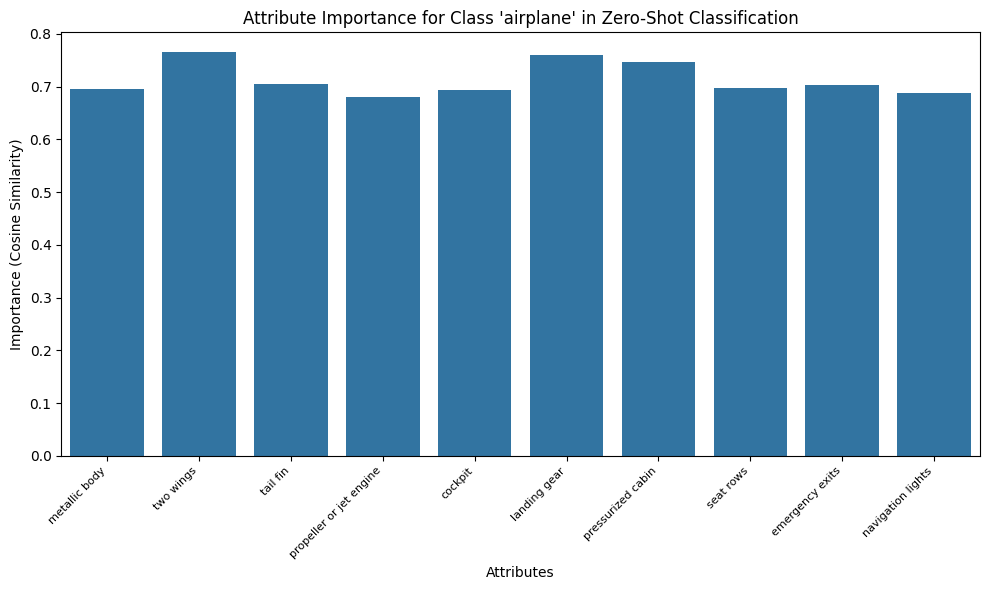

Most similar attributes for airplane: two wings, landing gear, pressurized cabin


In [ ]:
most_similar1 = {}
most_similar2 = {}
most_similar3 = {}
classname = 'airplane'
attributes = get_attributes10(classname)
attribute_embeddings = [extract_token_embedding(attr) for attr in attributes]
class_embedding = extract_token_embedding(classname)
importance_scores = compute_attribute_importance(attribute_embeddings, class_embedding)
importance_scores = [score.item() for score in importance_scores]
plot_attribute_importance(attributes, importance_scores, classname)
most_similar1[classname] = attributes[importance_scores.index(max(importance_scores))]
most_similar2[classname] = attributes[importance_scores.index(sorted(importance_scores)[-2])]
most_similar3[classname] = attributes[importance_scores.index(sorted(importance_scores)[-3])]
print(f"Most similar attributes for {classname}: {most_similar1[classname]}, {most_similar2[classname]}, {most_similar3[classname]}")

In [ ]:
print(attributes)
print(importance_scores)

['metallic body', 'two wings', 'tail fin', 'propeller or jet engine', 'cockpit', 'landing gear', 'pressurized cabin', 'seat rows', 'emergency exits', 'navigation lights']
[0.6961856484413147, 0.7647085189819336, 0.7044867873191833, 0.6804516315460205, 0.6935297846794128, 0.7601166367530823, 0.7468100786209106, 0.6979128122329712, 0.7038722634315491, 0.6881526708602905]


In [ ]:
# Boucle pour afficher le graphique pour chaque classe
most_similar1 = {}
most_similar2 = {}
most_similar3 = {}
for classname in cifar10.classes:
    attributes = get_attributes10(classname)
    attribute_embeddings = [extract_token_embedding(attr) for attr in attributes]
    class_embedding = extract_token_embedding(classname)
    importance_scores = compute_attribute_importance(attribute_embeddings, class_embedding)
    importance_scores = [score.item() for score in importance_scores]
    plot_attribute_importance(attributes, importance_scores, classname)
    most_similar1[classname] = attributes[importance_scores.index(max(importance_scores))]
    most_similar2[classname] = attributes[importance_scores.index(sorted(importance_scores)[-2])]
    most_similar3[classname] = attributes[importance_scores.index(sorted(importance_scores)[-3])]
    print(f"Most similar attributes for {classname}: {most_similar1[classname]}, {most_similar2[classname]}, {most_similar3[classname]}")

#### Pour 1 attribut

In [ ]:
templates_most_similar1 = {}
for classe in cifar10.classes:
  templates_most_similar1[classe] = [f"a photo of a {classe} because of {most_similar1[classe]}"]

zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates_most_similar1)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")


#### Pour 2 attributs :

In [ ]:
templates_most_similar2 = {}
for classe in cifar10.classes:
  templates_most_similar2[classe] = [f"a photo of a {classe} because of {most_similar1[classe]} and {most_similar2[classe]}"]

zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates_most_similar2)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")


#### Pour 3 attributs :

In [ ]:
templates_most_similar3 = {}
for classe in cifar10.classes:
  templates_most_similar3[classe] = [f"a photo of a {classe} because of {most_similar1[classe]}, {most_similar2[classe]} and {most_similar3[classe]}"]

zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates_most_similar3)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")


In [ ]:
def get_top_attributes(classname, num_attributes=10):
  """
  Identifies the top attributes for a given class based on cosine similarity.

  Args:
    classname: The name of the class to find attributes for.
    num_attributes: The number of top attributes to find.

  Returns:
    A list of the top attributes for the class.
  """
  top_attributes = []
  existing_attributes = None

  for _ in range(num_attributes):
    attributes = get_attributes10(classname, existing_attributes)
    attribute_embeddings = [extract_token_embedding(attr) for attr in attributes]
    class_embedding = extract_token_embedding(classname)
    importance_scores = compute_attribute_importance(attribute_embeddings, class_embedding)
    importance_scores = [score.item() for score in importance_scores]

    best_attribute_index = importance_scores.index(max(importance_scores))
    best_attribute = attributes[best_attribute_index]
    top_attributes.append(best_attribute)
    existing_attributes.append(best_attribute)

  return top_attributes

top_attributes_lists = {}

for classname in cifar10.classes:
  top_attributes_lists[classname] = get_top_attributes(classname)

top_attributes_lists




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

{'airplane': ['two engines',
  'winged design',
  'landing gear',
  'pressurized cabin',
  'fuselage',
  'cargo hold',
  'control surfaces',
  'paint scheme',
  'hump on fuselage',
  'swept-wing'],
 'automobile': ['four-door',
  'sporty design',
  'round headlights',
  'keyless entry',
  'push-button start',
  'adaptive cruise control',
  'automatic transmission',
  'tinted windows',
  'premium audio system',
  'dual-zone climate control'],
 'bird': ['long beak',
  'yellow beak',
  'blue wings',
  'short beak',
  'avian',
  'winged',
  'bird-song',
  'feathered',
  'bright eyes',
  'songbird'],
 'cat': ['white-paws',
  'short-tail',
  'tri-colored',
  'round-paws',
  'curled-tail',
  'green-eyes',
  'muscular-body',
  'purring-noise',
  'soft-fur',
  'blue-eyes'],
 'deer': ['hoofed',
  'antlers-male',
  'spotted',
  'graceful',
  'dark-eyed',
  'white-tail',
  'small hooves',
  'high-alertness',
  'soft-whitetail',
  'quick movements'],
 'dog': ['wagging tail',
  'wet nose',
  'spotted

In [ ]:
top_attributes_lists = {'airplane': ['two engines',
  'winged design',
  'landing gear',
  'pressurized cabin',
  'fuselage',
  'cargo hold',
  'control surfaces',
  'paint scheme',
  'hump on fuselage',
  'swept-wing'],
 'automobile': ['four-door',
  'sporty design',
  'round headlights',
  'keyless entry',
  'push-button start',
  'adaptive cruise control',
  'automatic transmission',
  'tinted windows',
  'premium audio system',
  'dual-zone climate control'],
 'bird': ['long beak',
  'yellow beak',
  'blue wings',
  'short beak',
  'avian',
  'winged',
  'bird-song',
  'feathered',
  'bright eyes',
  'songbird'],
 'cat': ['white-paws',
  'short-tail',
  'tri-colored',
  'round-paws',
  'curled-tail',
  'green-eyes',
  'muscular-body',
  'purring-noise',
  'soft-fur',
  'blue-eyes'],
 'deer': ['hoofed',
  'antlers-male',
  'spotted',
  'graceful',
  'dark-eyed',
  'white-tail',
  'small hooves',
  'high-alertness',
  'soft-whitetail',
  'quick movements'],
 'dog': ['wagging tail',
  'wet nose',
  'spotted',
  'hound-like',
  'dark-colored',
  'short snout',
  'rectangular face',
  'long hair',
  'round eyes',
  'floppy ears'],
 'frog': ['croaking voice',
  'large eyes',
  'toad-like appearance',
  'green',
  'eardrums on inner legs',
  'short body',
  'tadpole stage',
  'pointy snout',
  'moist skin',
  'smooth skin'],
 'horse': ['dark-eyes',
  'black tail',
  'black mane',
  'muscular build',
  'large, expressive eyes',
  'feathered fetlocks',
  'white socks',
  'white socks on hind legs',
  'white socks on hind legs',
  'white socks on hind legs, right'],
 'ship': ['large sailing vessel',
  'lifeboats',
  'steel hull',
  'grey hull',
  'life raft',
  'white superstructure',
  'blue hull',
  'cargo holds',
  'balconies on deck',
  'navigational lights'],
 'truck': ['four wheels',
  'powerful engine',
  'flatbed',
  'air intake',
  'cargo area',
  'tow hitch',
  'running boards',
  'spare tire',
  'heavy-duty bumper',
  'exhaust pipe at the back']}

templates1 = {}
templates2 = {}
templates3 = {}
templates4 = {}
templates5 = {}
templates6 = {}
templates7 = {}
templates8 = {}
templates9 = {}
templates10 = {}

for i in range(0,10) :
  templates1[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}"]
  templates2[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]} and {top_attributes_lists[cifar10.classes[i]][1]}"]
  templates3[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]} and {top_attributes_lists[cifar10.classes[i]][2]}"]
  templates4[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]} and {top_attributes_lists[cifar10.classes[i]][3]}"]
  templates5[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]}, {top_attributes_lists[cifar10.classes[i]][3]} and {top_attributes_lists[cifar10.classes[i]][4]}"]
  templates6[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]}, {top_attributes_lists[cifar10.classes[i]][3]}, {top_attributes_lists[cifar10.classes[i]][4]} and {top_attributes_lists[cifar10.classes[i]][5]}"]
  templates7[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]}, {top_attributes_lists[cifar10.classes[i]][3]}, {top_attributes_lists[cifar10.classes[i]][4]}, {top_attributes_lists[cifar10.classes[i]][5]} and {top_attributes_lists[cifar10.classes[i]][6]}"]
  templates8[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]}, {top_attributes_lists[cifar10.classes[i]][3]}, {top_attributes_lists[cifar10.classes[i]][4]}, {top_attributes_lists[cifar10.classes[i]][5]}, {top_attributes_lists[cifar10.classes[i]][6]} and {top_attributes_lists[cifar10.classes[i]][7]}"]
  templates9[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]}, {top_attributes_lists[cifar10.classes[i]][3]}, {top_attributes_lists[cifar10.classes[i]][4]}, {top_attributes_lists[cifar10.classes[i]][5]}, {top_attributes_lists[cifar10.classes[i]][6]}, {top_attributes_lists[cifar10.classes[i]][7]} and {top_attributes_lists[cifar10.classes[i]][8]}"]
  templates10[cifar10.classes[i]] = [f"a photo of a {cifar10.classes[i]} because of {top_attributes_lists[cifar10.classes[i]][0]}, {top_attributes_lists[cifar10.classes[i]][1]}, {top_attributes_lists[cifar10.classes[i]][2]}, {top_attributes_lists[cifar10.classes[i]][3]}, {top_attributes_lists[cifar10.classes[i]][4]}, {top_attributes_lists[cifar10.classes[i]][5]}, {top_attributes_lists[cifar10.classes[i]][6]}, {top_attributes_lists[cifar10.classes[i]][7]}, {top_attributes_lists[cifar10.classes[i]][8]} and {top_attributes_lists[cifar10.classes[i]][9]}"]

In [ ]:
import tqdm

def test_classifier_with_templates(templates):
  """
  Tests the classifier's performance using the provided templates.

  Args:
    templates: A dictionary mapping class names to lists of templates.
  """

  zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, templates)

  with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
      images = images.cuda()
      target = target.cuda()

      # Predict
      image_features = model.encode_image(images)
      image_features /= image_features.norm(dim=-1, keepdim=True)

      # Measure accuracy
      logits = 100. * image_features @ zeroshot_weights
      acc1, acc5 = accuracy(logits, target, topk=(1, 5))
      top1 += acc1
      top5 += acc5

      n += images.size(0)

  top1 = (top1 / n) * 100


  print()
  print(f"Top-1 accuracy: {top1:.2f}")


# Test with templates1, templates2, ..., templates10
test_classifier_with_templates(templates1)
test_classifier_with_templates(templates2)
test_classifier_with_templates(templates3)
test_classifier_with_templates(templates4)
test_classifier_with_templates(templates5)
test_classifier_with_templates(templates6)
test_classifier_with_templates(templates7)
test_classifier_with_templates(templates8)
test_classifier_with_templates(templates9)
test_classifier_with_templates(templates10)


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-19-3821fb981e91>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 10000/10000 [01:57<00:00, 84.82it/s]



Top-1 accuracy: 70.59


100%|██████████| 10000/10000 [01:52<00:00, 88.67it/s]



Top-1 accuracy: 73.00


100%|██████████| 10000/10000 [02:01<00:00, 82.51it/s]



Top-1 accuracy: 67.60


100%|██████████| 10000/10000 [01:48<00:00, 92.16it/s]



Top-1 accuracy: 68.69


100%|██████████| 10000/10000 [01:47<00:00, 92.85it/s]



Top-1 accuracy: 69.53


100%|██████████| 10000/10000 [01:48<00:00, 92.22it/s]



Top-1 accuracy: 65.76


100%|██████████| 10000/10000 [01:48<00:00, 92.02it/s]



Top-1 accuracy: 62.37


100%|██████████| 10000/10000 [01:47<00:00, 93.01it/s]



Top-1 accuracy: 55.35


100%|██████████| 10000/10000 [01:48<00:00, 92.54it/s]



Top-1 accuracy: 64.23


100%|██████████| 10000/10000 [01:47<00:00, 93.23it/s]


Top-1 accuracy: 62.93


## Fine-Tuning

In [ ]:
# prompt: on veut un dictionnaire de 10 attributs pour chaque classe en utilisant get_attributes10

attributes_dict = {}
for classname in cifar10.classes:
  attributes_dict[classname] = get_attributes10(classname)

attributes_dict


In [ ]:
def select_random_attribute_per_class(attributes_dict):
  """
  Selects a random attribute for each class from the given dictionary.

  Args:
    attributes_dict: A dictionary where keys are class names and values are lists of attributes.

  Returns:
    A dictionary with one random attribute per class.
  """
  selected_attributes = {}
  for classname, attributes in attributes_dict.items():
    random_attribute = random.choice(attributes)
    selected_attributes[classname] = random_attribute
  return selected_attributes



In [ ]:
def create_templates(selected_attributes):
  """
  Creates templates for each class using the selected attributes.

  Args:
    selected_attributes: A dictionary with one attribute per class.

  Returns:
    A dictionary where keys are class names and values are lists of templates.
  """
  templates = {}
  for classname, attr1 in selected_attributes.items():
    templates[classname] = [f"a photo of a {classname} because of {attr1}"]
  return templates


In [ ]:
import torch.optim as optim

# 1. Préparer les données
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=32, shuffle=True)

# 2. Modifier le modèle
for param in model.parameters():
    param.requires_grad = False  # Geler tous les paramètres

# Définir les couches à réentraîner
for param in model.visual.layer4[-2:].parameters():
    param.requires_grad = True
for param in model.transformer.resblocks[-2:].parameters():
    param.requires_grad = True

# 3. Définir la fonction de perte
criterion = torch.nn.CrossEntropyLoss()

# 4. Entraîner le modèle
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

epochs = 10  # Nombre d'epochs d'entraînement
for epoch in range(epochs):
    for images, targets in tqdm.tqdm(train_loader):
        images = images.cuda()
        targets = targets.cuda()

        # Obtenir les embeddings d'image et de texte
        image_features = model.encode_image(images)

        # --- Correction ---
        # Créer une liste de templates correspondant aux targets du batch
        text_templates = [best_templates[cifar10.classes[target.item()]][0] for target in targets]
        # Tokeniser les templates et les envoyer au GPU
        text_tokens = clip.tokenize(text_templates).cuda()
        # Encoder les templates
        text_features = model.encode_text(text_tokens)
        # --- Fin de la correction ---

        # Calculer la perte
        logits_per_image = image_features @ text_features.T # Similarité cosinus pour chaque image/template
        probs = torch.nn.functional.softmax(logits_per_image, dim=1)  # Appliquer softmax sur la dimension 1 (classes)
        loss = criterion(probs, targets)

        # Mettre à jour les paramètres du modèle
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 313/313 [00:52<00:00,  5.96it/s]


In [ ]:
from torch.utils.data import Subset

cifar10_2 = CIFAR10(root=os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=True)
cifar10_dim = Subset(cifar10_2, range(5000))
data_loader = torch.utils.data.DataLoader(cifar10_dim, batch_size=32, shuffle=True)

zeroshot_weights = zeroshot_classifier_with_attributes(cifar10.classes, best_templates)

with torch.no_grad():
  top1, top5, n = 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print()
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-22-07f05e45ae7b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 157/157 [00:19<00:00,  8.08it/s]


Top-1 accuracy: 9.20
Top-5 accuracy: 49.78
